In [1]:
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
import seaborn as sns
import re
from pprint import pprint
import collections
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import string
from nltk.stem import WordNetLemmatizer

In [2]:
data = pd.read_csv("WhatsAppMessages.csv")

In [3]:
def clean_df(df, columnToClean):
    """ 
    apply regular expression cleaning to dataframe
    """
    
    df["Clean"]=columnToClean
    # removes non ASCII characters
    df.Clean = df.Clean.str.replace(r'[^\x00-\x7f]',r'', regex=True)
    # make everything lowercase
    df.Clean = [i.lower() for i in df.Clean]
    # removes all but white space or word character
    df.Clean = [re.sub(r'[^\w\s]','', i) for i in df.Clean]
    # remove digit
    df.Clean = [re.sub(r'\d+', '', i) for i in df.Clean]
    # remove url
    df.Clean = [re.sub(r'http\S*\s\S*', '', i) for i in df.Clean]
    # strip whitespace
    df.Clean = df.Clean.str.replace(r'^\s*$',r'', regex=True)
    
    return df

In [4]:
data = clean_df(data, data.Message)
data.Author = data.Author.str.replace(r'Rushpreet','Rashpreet')

In [5]:
# blind the names
j = 0
for i in data.Author.unique():
    data.Author = data.Author.str.replace(i, "Author %d" %j)
    j += 1

<AxesSubplot:xlabel='count', ylabel='Author'>

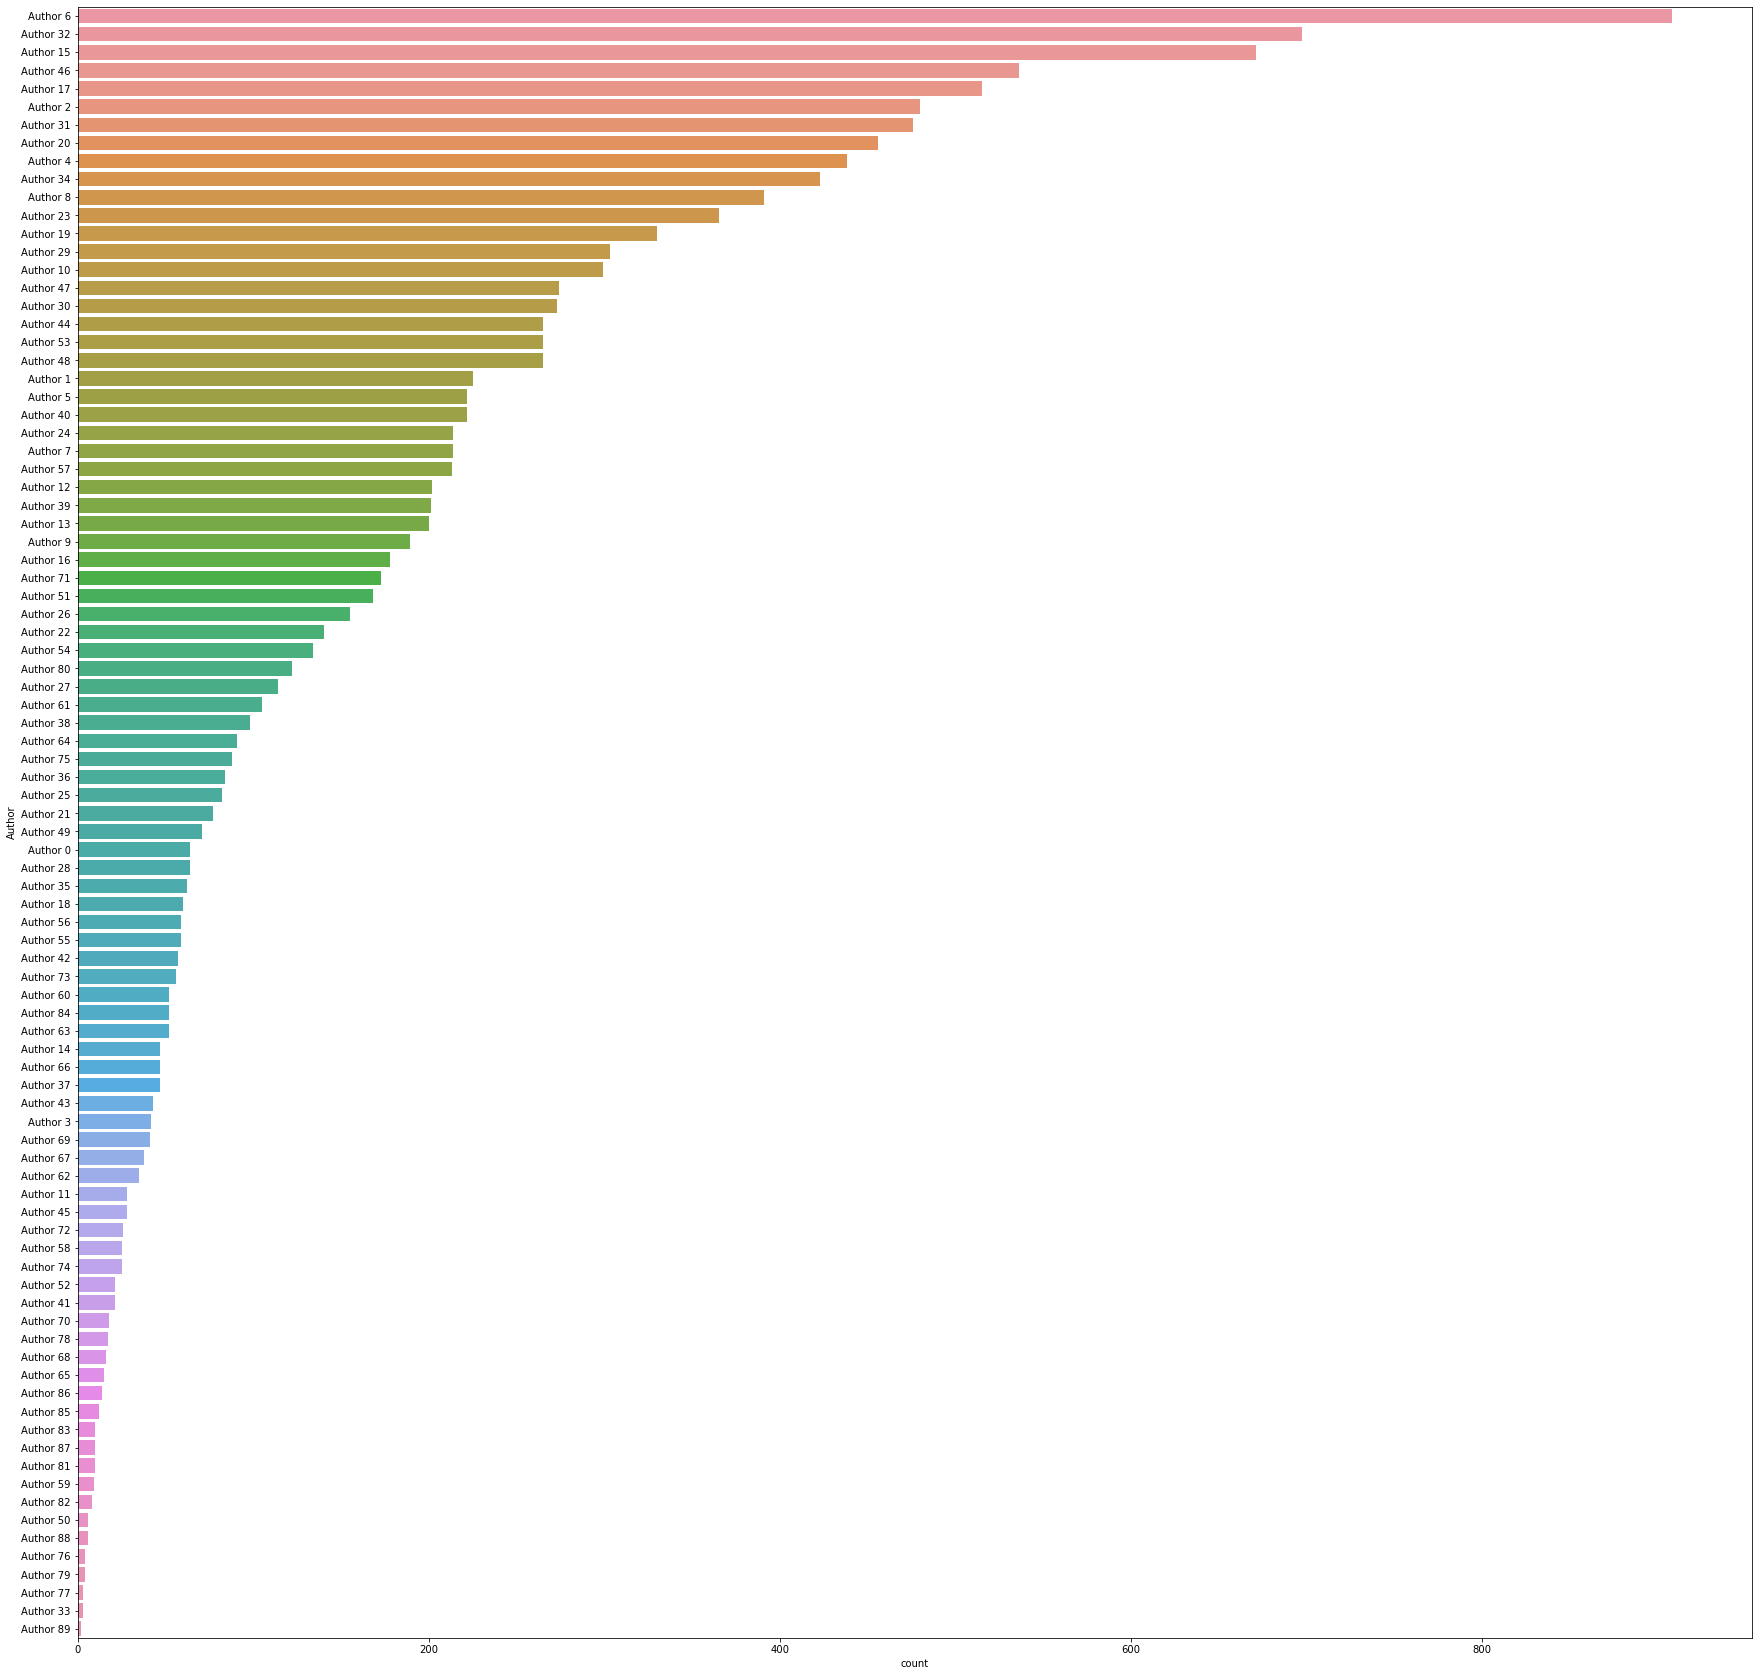

In [6]:
plt.figure(figsize=(30,30))
sns.countplot(y="Author",data=data, order = data.Author.value_counts().index)

<AxesSubplot:>

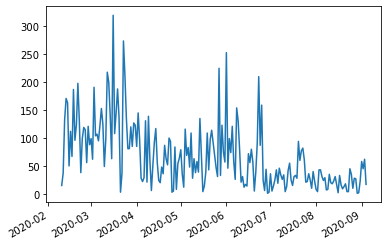

In [7]:
x = data.Date.value_counts()
x.index = pd.to_datetime(x.index, format="%d/%m/%y")
x.plot()

In [8]:
from datetime import datetime
import datetime as dt

<AxesSubplot:xlabel='time'>

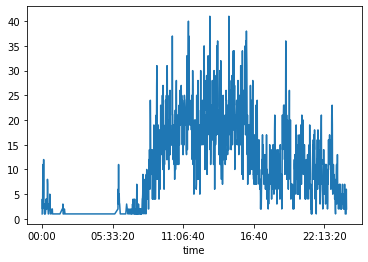

In [9]:
y = [datetime.strptime(i, " %I:%M:%S %p") for i in data.Time]
# isolate just the time
y = [i.time() for i in y]
y = pd.DataFrame(y,columns = ["Time"])
y.Time = [dt.time(i.hour, i.minute,0) for i in y.Time]

y.Time.value_counts().plot()

In [10]:
data.Clean.replace("", np.NaN, inplace=True)
textData = data.Clean.dropna().tolist()

In [11]:
def process_text(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    text = text.translate(str.maketrans(string.punctuation, " "*len(string.punctuation))
                         ).replace(" "*4, " ").replace(" "*3," ").replace(" "*2," ").strip()
    tokens = word_tokenize(text)
 
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
 
    return tokens
 

def cluster_texts(texts, clusters=3):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    vectorizer = TfidfVectorizer(tokenizer=process_text,
                                 stop_words=stopwords.words('english'),
                                 max_df=0.3,
                                 min_df=0.01,
                                 lowercase=True)
    tfidf_model = vectorizer.fit_transform(texts)
    km_model = KMeans(n_clusters=clusters)
    km_model.fit(tfidf_model)
    
    print("Top words per Cluster")
    order_centroids = km_model.cluster_centers_.argsort()[:,::-1]
    terms = vectorizer.get_feature_names()
    for i in range(clusters):
        print("Cluster %d:" %i),
        for ind in order_centroids[i, :15]:
            print(" %s" % terms[ind]),
        print
    
    clustering = collections.defaultdict(list)
 
    for idx, label in enumerate(km_model.labels_):
        clustering[label].append(idx)
 
    # plot the clusters
    kmean_indices = km_model.fit_predict(tfidf_model)
    pca = PCA(n_components=3)
    scatter_plot_points = pca.fit_transform(tfidf_model.toarray())
    colors = ["r", "b", "violet", "lime", "black", "darkkhaki", "darkgray", 
              "paleturquoise", "c", "y", "m", "bisque"]
    x_axis = [o[0] for o in scatter_plot_points]
    y_axis = [o[1] for o in scatter_plot_points]
    z_axis = [o[2] for o in scatter_plot_points]
    ax = plt.axes(projection="3d")

    ax.scatter3D(x_axis, y_axis, z_axis, c=[colors[d] for d in kmean_indices])
    ax.view_init(elev=10., azim=180)
    
    # calculate distortion
    distortion = []
    K = range(1,10)
    for k in K:
        kModel = KMeans(n_clusters=k)
        kModel.fit(tfidf_model)
        distortion.append(kModel.inertia_)
    plt.figure(figsize=(10,5))
    plt.plot(K, distortion, "bx-")
    plt.title("Elbow Graph")


    return clustering

C:\Users\chiugabr\Anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Top words per Cluster
Cluster 0:
 thi
 lol
 anyon
 wa
 class
 get
 like
 good
 think
 im
 know
 one
 go
 ye
 dont
Cluster 1:
 thank
 much
 thi
 awesom
 everyon
 guy
 amaz
 great
 oh
 good
 got
 ill
 lol
 work
 im
Cluster 2:
 happi
 birthday
 day
 one
 hope
 great
 good
 everyon
 awesom
 thi
 see
 amaz
 hey
 also
 hahaha


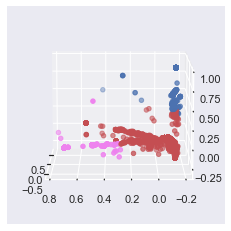

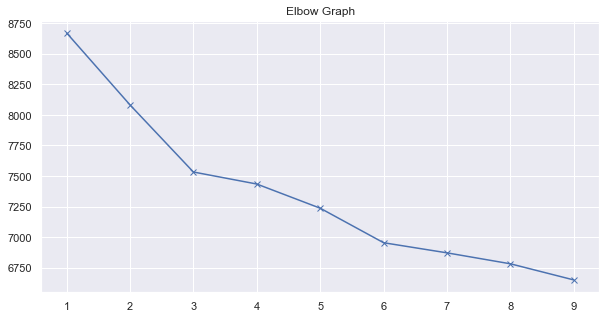

In [12]:
np.random.seed(20200908)
sns.set()
clustering = cluster_texts(textData, clusters=3)

In [13]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

C:\Users\chiugabr\Anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Top words per Cluster
Cluster 0:
 happi
 birthday
 day
 one
 hope
 great
 good
 everyon
 awesom
 thi
 see
 amaz
 hey
 also
 hahaha
Cluster 1:
 like
 look
 feel
 thi
 would
 im
 wa
 get
 anyon
 know
 class
 time
 go
 also
 make
Cluster 2:
 thi
 lol
 anyon
 class
 wa
 get
 good
 think
 ye
 one
 im
 go
 know
 dont
 everyon
Cluster 3:
 thank
 much
 thi
 awesom
 everyon
 guy
 great
 amaz
 oh
 good
 got
 ill
 lol
 work
 im


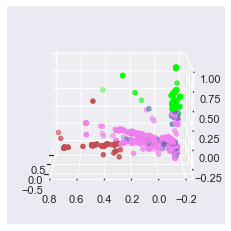

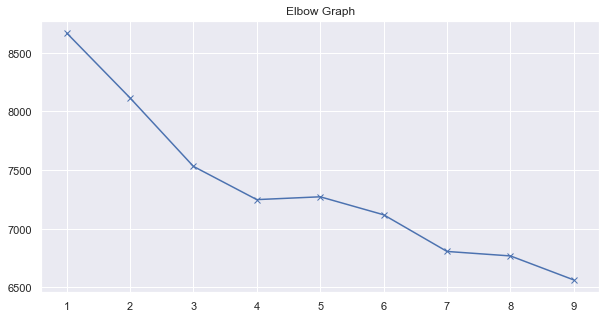

In [14]:
np.random.seed(31415)
sns.set()
clustering = cluster_texts(textData, clusters=4)

In [15]:
def processL_text(text, lem=True):
    """ Tokenize text and stem words removing punctuation """
    text = text.translate(str.maketrans(string.punctuation, " "*len(string.punctuation))
                         ).replace(" "*4, " ").replace(" "*3," ").replace(" "*2," ").strip()
    tokens = word_tokenize(text)
 
    if lem:
        lemmer = WordNetLemmatizer()
        tokens = [lemmer.lemmatize(t) for t in tokens]
 
    return tokens
 

def clusterL_texts(texts, clusters=3):
    """ Transform texts to Tf-Idf coordinates and cluster texts using K-Means """
    vectorizer = TfidfVectorizer(tokenizer=processL_text,
                                 stop_words=stopwords.words('english'),
                                 max_df=0.8,
                                 min_df=20,
                                 lowercase=True)
    tfidf_model = vectorizer.fit_transform(texts)
    km_model = KMeans(n_clusters=clusters)
    km_model.fit(tfidf_model)
    
    print("Top words per Cluster")
    order_centroids = km_model.cluster_centers_.argsort()[:,::-1]
    terms = vectorizer.get_feature_names()
    for i in range(clusters):
        print("Cluster %d:" %i),
        for ind in order_centroids[i, :15]:
            print(" %s" % terms[ind]),
        print
    
    clustering = collections.defaultdict(list)
 
    for idx, label in enumerate(km_model.labels_):
        clustering[label].append(idx)
 
    # plot the clusters
    kmean_indices = km_model.fit_predict(tfidf_model)
    pca = PCA(n_components=3)
    scatter_plot_points = pca.fit_transform(tfidf_model.toarray())
    colors = ["r", "b", "violet", "lime", "black", "darkkhaki", "darkgray", 
              "c", "y", "m", "w", "orange", "olive", "hotpink", "lightseagreen"]
    x_axis = [o[0] for o in scatter_plot_points]
    y_axis = [o[1] for o in scatter_plot_points]
    z_axis = [o[2] for o in scatter_plot_points]
    ax = plt.axes(projection="3d")
    
    plt.figure()
    ax.scatter3D(x_axis, y_axis, z_axis, c=[colors[d] for d in kmean_indices])
    plt.figure()
    ax.view_init(elev=20., azim=270)
    # calculate distortion
    distortion = []
    K = range(1,25)
    for k in K:
        kModel = KMeans(n_clusters=k)
        kModel.fit(tfidf_model)
        distortion.append(kModel.inertia_)
    plt.figure(figsize=(10,5))
    plt.plot(K, distortion, "bx-")
    plt.title("Elbow Graph")


    return clustering

C:\Users\chiugabr\Anaconda3\envs\nlp\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['doe', 'ha', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Top words per Cluster
Cluster 0:
 thanks
 jackie
 kev
 awesome
 much
 great
 abdullah
 sharing
 guy
 everyone
 freddy
 amazing
 man
 okay
 omar
Cluster 1:
 yes
 lol
 please
 oh
 thanks
 omg
 great
 haha
 interview
 hahaha
 right
 say
 ramya
 naanak
 im
Cluster 2:
 lol
 thank
 class
 wa
 anyone
 u
 like
 good
 done
 know
 get
 im
 think
 one
 dont
Cluster 3:
 birthday
 happy
 aditi
 jane
 alison
 lucy
 alex
 maia
 brady
 lynn
 jackie
 sherin
 yushen
 abdullah
 ankit
Cluster 4:
 sure
 im
 make
 pretty
 wa
 one
 check
 think
 sorry
 right
 lol
 dont
 everyone
 though
 please


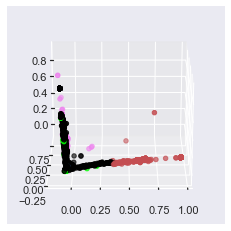

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

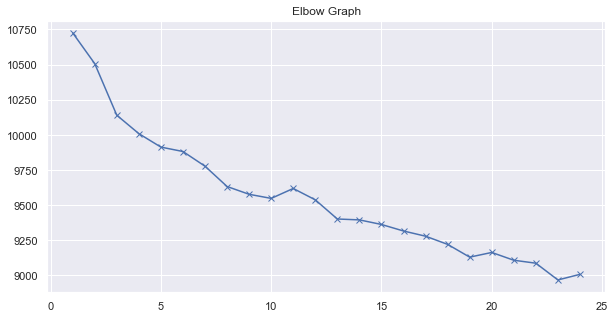

In [16]:
np.random.seed(20200908)
sns.set()
clusteringL = clusterL_texts(textData, clusters=5)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.01, 
                             max_features=1000, ngram_range=[1,3])
dtm = vectorizer.fit_transform(data.Clean.dropna())

from sklearn.decomposition import LatentDirichletAllocation
np.random.seed(31415)
lda_model = LatentDirichletAllocation(n_components=20,
                                      doc_topic_prior=None,
                                      topic_word_prior=None,
                                      max_iter=200, 
                                      learning_method='batch', 
                                      random_state=123,
                                      n_jobs=2,
                                      verbose=0)
lda_output = lda_model.fit(dtm)

# Log Likelyhood: Higher the better
ll = lda_model.score(dtm)

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
perp = lda_model.perplexity(dtm)

# theta hyperparameter - number of topics per document. document topic density.
theta = pd.DataFrame(lda_model.transform(dtm))

# beta hyperparameter - number of words per topic. topic word density
beta = pd.DataFrame(lda_model.components_)


# Build Topic Summary
feature_names = vectorizer.get_feature_names()
weight = theta.sum(axis=0)
support50 = (theta > 0.5).sum(axis=0)
support10 = (theta > 0.1).sum(axis=0)
termss = list()
for topic_id, topic in enumerate(lda_model.components_):
    terms = " ".join([feature_names[i] for i in topic.argsort()[:-6 - 1:-1]])
    termss.append(terms)
topic_summary = pd.DataFrame({'TopicID': range(0, len(termss)), "Support50": support50, "Support10": support10, "Weight": weight, "Terms": termss})

pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 0)


# elbow graph
distortion = []
K = range(1,25)
for k in K:
    ldaModel = LatentDirichletAllocation(n_components=k,
                                      doc_topic_prior=None,
                                      topic_word_prior=None,
                                      max_iter=200, 
                                      learning_method='batch', 
                                      random_state=123,
                                      n_jobs=2,
                                      verbose=0)
    ldaModel.fit(dtm)
    distortion.append(ldaModel.perplexity(dtm))


    TopicID  Support50  Support10      Weight                                        Terms
0         0        572       1016  782.044297                       we do to get have need
1         1        659       1022  814.742151                      to good the can you out
2         2        289        926  608.304255               was that right from has anyone
3         3        343        783  612.139351                       an some it see to only
4         4        143        764  489.801693                thats like he amazing ill one
5         5        252        637  518.176535      thank you thank you everyone much youre
6         6        434        985  613.319643                    thanks too me for this it
7         7        335       1020  657.125334                 in of hahaha the in the were
8         8        212        763  500.327614                   yes my guys team still you
9         9        497        974  724.241323                will yeah be will be the said

Text(0.5, 0, 'Topics')

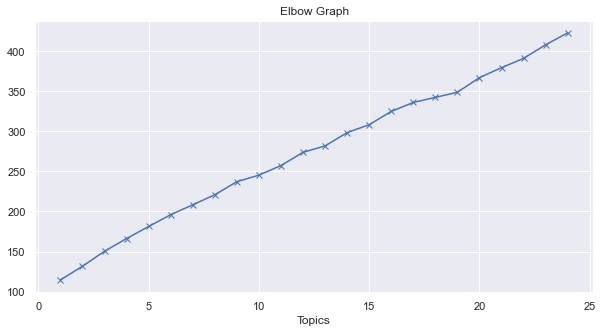

In [18]:
pprint(topic_summary)
plt.figure(figsize=(10,5))
plt.plot(K, distortion, "bx-")
plt.title("Elbow Graph")
plt.xlabel("Topics")

In [19]:
from sklearn.decomposition import NMF

In [20]:
def topWords(model, featureNames, n_topWords):
    output = []
    for topic_idx, topic in enumerate(model):
        top_words = [featureNames[i] for i in topic.argsort()[:-n_topWords - 1: -1]]
        output.append([str(topic_idx)] + top_words)
    return pd.DataFrame(output)
        
def NMFprocess(data, n_components, n_topWords):
    vectorizer = TfidfVectorizer(max_df=0.8, min_df=10, 
                                 max_features=1000, ngram_range=[2,3])
    dtm = vectorizer.fit_transform(data)
    nmf = NMF(n_components = n_components, random_state = 1, alpha = 0.1, l1_ratio=0.5)
    W = nmf.fit_transform(dtm)
    H = nmf.components_
    
    top_Words = topWords(H, vectorizer.get_feature_names(), n_topWords)
    
    W_df = pd.DataFrame(W, columns = ["topic {}".format(i) for i in range(n_components)])
    H_df = pd.DataFrame(H, columns=vectorizer.get_feature_names())
    
    return W_df, H_df, top_Words

In [21]:
W_df, H_df, topWords = NMFprocess(data.Clean.dropna(), 75, 30)

In [22]:
W_df

topic 0  topic 1  topic 2  topic 3  topic 4  topic 5  ...  topic 69  topic 70  topic 71  topic 72  topic 73  topic 74
0          0.0      0.0      0.0      0.0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0
1          0.0      0.0      0.0      0.0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0
2          0.0      0.0      0.0      0.0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0
3          0.0      0.0      0.0      0.0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0
4          0.0      0.0      0.0      0.0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0
...        ...      ...      ...      ...      ...      ...  ...       ...       ...       ...       ...       ...       ...
12214      0.0      0.0      0.0      0.0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0
12215      0.0      0.0      0.0      0.0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0
12216      0.0      0.0      0.0      0.0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0
12217      0.0      0.0      0.0      0.0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0
12218      0.0      0.0      0.0      0.0      0.0      0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0

[12219 rows x 75 columns]

In [23]:
H_df

able to  about how  about it  ...  zoom meeting  zoom meeting httpzoomustest  zoom meeting meeting
0   0.000000        0.0       0.0  ...           0.0                          0.0                   0.0
1   0.000000        0.0       0.0  ...           0.0                          0.0                   0.0
2   0.000000        0.0       0.0  ...           0.0                          0.0                   0.0
3   0.000381        0.0       0.0  ...           0.0                          0.0                   0.0
4   0.000000        0.0       0.0  ...           0.0                          0.0                   0.0
..       ...        ...       ...  ...           ...                          ...                   ...
70  0.000000        0.0       0.0  ...           0.0                          0.0                   0.0
71  0.000000        0.0       0.0  ...           0.0                          0.0                   0.0
72  0.000000        0.0       0.0  ...           0.0                          0.0                   0.0
73  0.000000        0.0       0.0  ...           0.0                          0.0                   0.0
74  0.000000        0.0       0.0  ...           0.0                          0.0                   0.0

[75 rows x 1000 columns]

In [ ]:
topWords.to_csv("topWords-5.csv", index=False)